# **Predicting the podiums of the formula 1 silverstone race**


#### Of all the tracks I chose this one in particular, because the first Grand Prix of the World Championship was held in 1950 at Silverstone.

### Let's start with our model!

#### First, we import the libraries we will need later on

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import autokeras as ak
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#### We read our data

In [2]:
data = pd.read_csv('dataFormula1.csv')
data = data.drop('Unnamed: 0', axis =1)

### Before we start training a model, let's dig a little deeper into the dataset to find out what data it is made of.

In [3]:
data.head()

,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,...,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,1983,1,jacarepagua,0,0,1,0,0,keke_rosberg,Finnish,...,1,15,0,0,0,0,0,0,0.0,34
1,1983,1,jacarepagua,0,0,1,0,0,prost,French,...,2,6,0,0,0,0,0,0,0.2,28
2,1983,1,jacarepagua,0,0,1,0,0,tambay,French,...,3,4,0,0,0,0,0,0,0.3,33
3,1983,1,jacarepagua,0,0,1,0,0,piquet,Brazilian,...,4,1,0,0,0,0,0,0,0.6,30
4,1983,1,jacarepagua,0,0,1,0,0,warwick,British,...,5,7,0,0,0,0,0,0,0.7,28


In [4]:
data.shape

(14566, 21)

In [5]:
data.season

0        1983
1        1983
2        1983
3        1983
4        1983
         ... 
14561    2020
14562    2020
14563    2020
14564    2020
14565    2020
Name: season, Length: 14566, dtype: int64

#### We can see that we have a dataset with 21 columns (season, round, circuit_id, etc) and with 14 734 lines that go from the year 1983 to 2021

#### Something important that we must know when working with data, is to know if any column has missing or null data

In [6]:
print(data.isnull().sum())
print("Total null values count: ", data.isnull().sum().sum())

season                       0
round                        0
circuit_id                   0
weather_warm                 0
weather_cold                 0
weather_dry                  0
weather_wet                  0
weather_cloudy               0
driver                       0
nationality                  0
constructor                  0
grid                         0
podium                       0
driver_points                0
driver_wins                  0
driver_standings_pos         0
constructor_points           0
constructor_wins             0
constructor_standings_pos    0
qualifying_time              0
driver_age                   0
dtype: int64
Total null values count:  0


#### We can see that the dataset has no null values!

#### I decided to make a word cloud with the different drivers names that appear in the dataset

In [7]:
wordcloud2 = WordCloud().generate(' '.join(data['driver']))

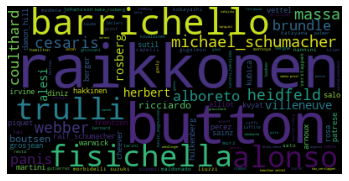

In [8]:
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

### As a general thing, I am curious about the distribution of nationalities from when formula 1 began until current dates and we can know that with our data, let's see!

<Figure size 1080x720 with 0 Axes>

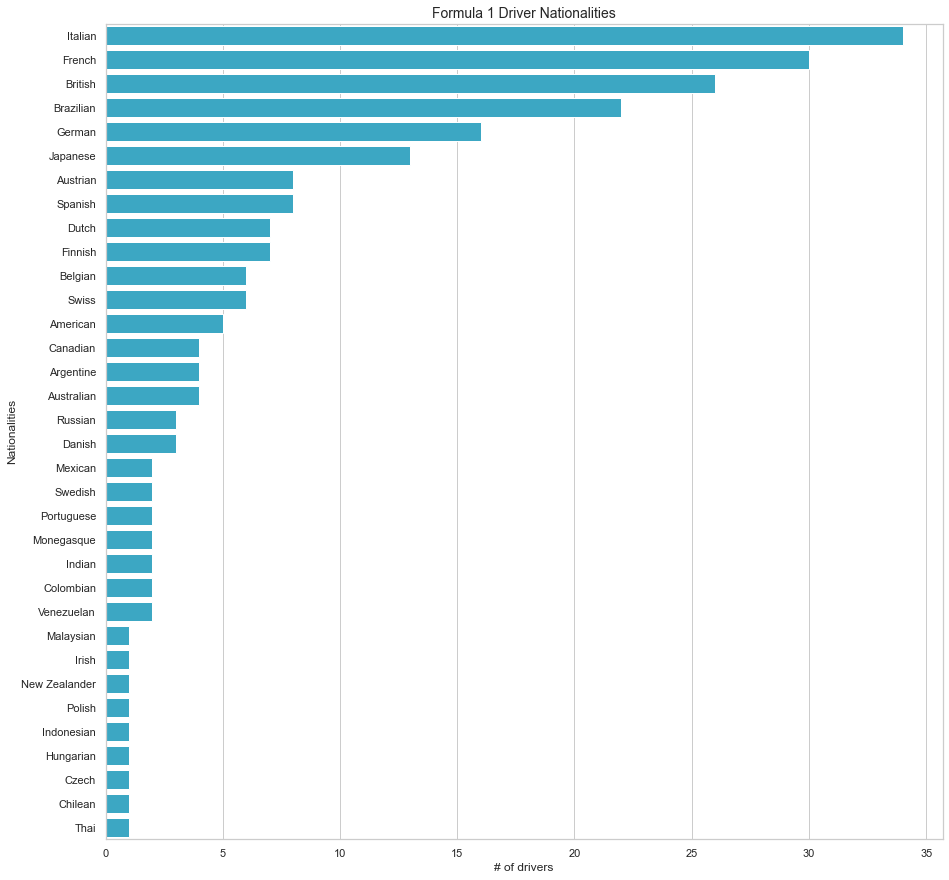

In [9]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(15,10))

df_tmp = data.groupby('nationality',as_index=False)\
  .agg(count_drivers = pd.NamedAgg(column='driver',aggfunc='nunique'))\
  .sort_values('count_drivers',ascending=False)

plt.figure(figsize=(15,15))

graph = sns.barplot(
    data=df_tmp,
    y ='nationality',
    x='count_drivers',
    color='#25B5D9'
     ).set_title(
    'Formula 1 Driver Nationalities',
    size=14
    )

plt.xlabel('# of drivers')
plt.ylabel('Nationalities')

plt.savefig('drivers.png')

#### (We could answer any more questions we have but that is not the main purpose of this project.)

## Now it's time to prepare our data for training!

#### Before choosing which columns we want to train with, let's pass all of them to a numerical value, so in the end we have freedom to choose between all the columns

#### One of the columns is "nationality", so we will give a numerical value to each unique value in this column.

In [10]:
data.nationality.unique()

array(['Finnish', 'French', 'Brazilian', 'British', 'Italian', 'American',
       'Austrian', 'Colombian', 'Venezuelan', 'Swiss', 'German',
       'Chilean', 'Australian', 'Belgian', 'Swedish', 'Dutch', 'Canadian',
       'Japanese', 'Spanish', 'Argentine', 'Portuguese', 'Monegasque',
       'Danish', 'Czech', 'Malaysian', 'Irish', 'Hungarian', 'Indian',
       'Polish', 'Russian', 'Mexican', 'Indonesian', 'New Zealander',
       'Thai'], dtype=object)

In [11]:
data["nationality"].replace({"Finnish": 1, "French": 2, "Brazilian": 3, "British": 4, "Italian": 5, "American": 6,"Austrian": 7, "Colombian": 8, "Venezuelan": 9, "Swiss": 10, "German": 11, "Chilean": 12,
                            "Australian": 13, "Belgian": 14, "Swedish": 15, "Dutch": 16, "Canadian": 17,"Japanese": 18, "Spanish": 19, "Argentine": 20, "Portuguese": 21, "Monegasque": 22, "Danish": 23,
                            "Czech": 24, "Malaysian": 25, "Irish": 26, "Hungarian": 27, "Indian": 28, "Polish": 29,"Russian": 30, "Mexican": 31, "Indonesian": 32, "New Zealander": 33, "Thai": 34}, inplace=True)


#### We will do the same as we did with the nationality column, with the constructor column and circuit_id

In [12]:
data['constructor'].replace({"williams": 1, "renault": 2, "ferrari": 3, "brabham": 4, "toleman": 5, "mclaren": 6,"alfa": 7, "ligier": 8, "team_lotus": 9, "theodore": 10, 
                             "arrows": 11, "osella": 12,"ats": 13, "ram": 14, "spirit": 15, "minardi": 16, "zakspeed": 17,"lola": 18, "benetton": 19, "ags": 20, 
                             "march": 21, "larrousse": 22, "coloni": 23, "rial": 24, "eurobrun": 25, "dallara": 26, "onyx": 27, "leyton": 28, "jordan": 29,"lambo": 30, 
                             "footwork": 31, "fondmetal": 32, "moda": 33, "sauber": 34, "pacific": 35, "simtek": 36, "forti": 37, "prost": 38, "stewart": 39,"bar": 40, 
                             "jaguar": 41, "toyota": 42, "red_bull": 43, "honda": 44, "bmw_sauber": 45, "toro_rosso": 46, "mf1": 47, "super_aguri": 48, "spyker_mf1": 49,"spyker": 50, 
                             "force_india": 51, "brawn": 52, "mercedes": 53, "virgin": 54, "lotus_racing": 55, "hrt": 56, "lotus_f1": 57, "caterham": 58, "marussia": 59,"manor": 60, 
                             "haas": 61, "racing_point": 62, "alphatauri": 63, "alpine": 64, "aston_martin": 65, "tyrrell": 66}, inplace=True)

In [13]:
data['circuit_id'].replace({"jacarepagua": 1, "long_beach": 2, "ricard": 3, "imola": 4, "monaco": 5, "spa": 6,"detroit": 7, "villeneuve": 8, "silverstone": 9, "hockenheimring": 10, 
                             "osterreichring": 11, "zandvoort": 12,"monza": 13, "brands_hatch": 14, "kyalami": 15, "zolder": 16, "dijon": 17,"dallas": 18, "nurburgring": 19, "estoril": 20, 
                            "adelaide": 21, "jerez": 22, "hungaroring": 23, "rodriguez": 24, "suzuka": 25, "phoenix": 26, "interlagos": 27, "magny_cours": 28, "catalunya": 29,"donington": 30, 
                            "okayama": 31, "galvez": 32, "albert_park": 33, "sepang": 34, "indianapolis": 35, "bahrain": 36, "shanghai": 37, "istanbul": 38, "fuji": 39,"valencia": 40, 
                             "marina_bay": 41, "yas_marina": 42, "yeongam": 43, "buddh": 44, "americas": 45, "red_bull_ring": 46, "sochi": 47, "BAK": 48, "mugello": 49,"portimao": 50}, inplace=True)

#### As our goal is to predict the silverstone race, we will filter only our data from previous years that are from the silverstone track.

In [14]:
#data que contiene a silverstone
dataSilverstone=data['circuit_id']==9 #we give it the value of 9 because when we converted the column to a numeric value, the value "silverstone" took the value of 9
filtered_df = data[dataSilverstone]
filtered_df.head()

,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,...,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
202,1983,9,9,0,0,0,0,0,arnoux,2,...,1,5,17,1,5,44,2,2,0.0,35
203,1983,9,9,0,0,0,0,0,tambay,2,...,2,3,27,1,3,44,2,2,0.6,34
204,1983,9,9,0,0,0,0,0,prost,2,...,3,1,30,2,1,44,2,1,0.7,28
205,1983,9,9,0,0,0,0,0,angelis,5,...,4,26,0,0,22,1,0,8,1.3,25
206,1983,9,9,0,0,0,0,0,patrese,5,...,5,22,0,0,24,27,1,4,1.4,29


### Preparing the data

In [21]:
train = filtered_df

#### As a first test, we will train our x without the columns of 'driver', 'podium', 'round', I will also remove "circuit_id" because as all the data are from the same circuit, it does not contribute anything to put it, and we will train our y with podium values it

In [16]:
X_train = train.drop(['driver', 'podium', 'round', 'circuit_id'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

#### Fitting a classification model using auto-keras

In [17]:
tf.keras.backend.set_floatx('float64')
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=2) #max_trials is the number of models to test
clf.fit(X_train, y_train, epochs=400)

Trial 2 Complete [00h 01m 45s]
val_accuracy: 0.08955223880597014

Best val_accuracy So Far: 0.11194029850746269
Total elapsed time: 00h 01m 53s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass

#### Now let's try removing the columns with the driver's information, such as the number of races won, his points, and age and see what happens.

In [18]:
X_train = train.drop(['driver', 'podium', 'round', 'circuit_id', 'constructor', 'driver_points', 'driver_wins', 'driver_standings_pos', 'driver_age'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

tf.keras.backend.set_floatx('float64')
clf3 = ak.StructuredDataClassifier(overwrite=True, max_trials=2) #max_trials is the number of models to test
clf3.fit(X_train, y_train, epochs=350)

Trial 2 Complete [00h 00m 08s]
val_accuracy: 0.07462686567164178

Best val_accuracy So Far: 0.11194029850746269
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass

#### But let's see what happens if we remove more columns, now, let's train our x without the 'driver', 'podium', 'round', "circuit_id" columns and now let's see how it gives us the result if we also remove the constructor column.

In [24]:
X_train = train.drop(['driver', 'podium', 'round', 'circuit_id', 'constructor'], axis = 1)
y_train = train.podium

scaler = StandardScaler() #For standardization
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

tf.keras.backend.set_floatx('float64')
clf2 = ak.StructuredDataClassifier(overwrite=True, max_trials=2) #max_trials is the number of models to test
clf2.fit(X_train, y_train, epochs=350)

Trial 2 Complete [00h 00m 08s]
val_accuracy: 0.11194029850746269

Best val_accuracy So Far: 0.11194029850746269
Total elapsed time: 00h 00m 17s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass

### There are a huge number of combinations, but for the purposes of this project let's stick with the one that gave us an accuracy of 0.9974.

###  Testing

In [51]:
X_test = pd.read_csv('testSilverstone.csv')

X_test = X_test.drop('Unnamed: 0', axis =1)
X_test.head()

,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,...,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,2020,5,silverstone,1,0,0,0,0,bottas,Finnish,...,1,3,58,1,2,146,4,1,0.0,30
1,2020,5,silverstone,1,0,0,0,0,hamilton,British,...,2,2,88,3,1,146,4,1,0.0,35
2,2020,5,silverstone,1,0,0,0,0,hulkenberg,German,...,3,7,0,0,21,42,0,5,0.9,32
3,2020,5,silverstone,1,0,0,0,0,max_verstappen,Dutch,...,4,1,52,0,3,78,0,2,1.0,22
4,2020,5,silverstone,1,0,0,0,0,ricciardo,Australian,...,5,14,20,0,9,32,0,6,1.1,31


In [52]:
X_test["nationality"].replace({"Finnish": 1, "French": 2, "Brazilian": 3, "British": 4, "Italian": 5, "American": 6,"Austrian": 7, "Colombian": 8, "Venezuelan": 9, "Swiss": 10, "German": 11, "Chilean": 12,
                            "Australian": 13, "Belgian": 14, "Swedish": 15, "Dutch": 16, "Canadian": 17,"Japanese": 18, "Spanish": 19, "Argentine": 20, "Portuguese": 21, "Monegasque": 22, "Danish": 23,
                            "Czech": 24, "Malaysian": 25, "Irish": 26, "Hungarian": 27, "Indian": 28, "Polish": 29,"Russian": 30, "Mexican": 31, "Indonesian": 32, "New Zealander": 33, "Thai": 34}, inplace=True)
X_test.head()

,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,...,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,2020,5,silverstone,1,0,0,0,0,bottas,1,...,1,3,58,1,2,146,4,1,0.0,30
1,2020,5,silverstone,1,0,0,0,0,hamilton,4,...,2,2,88,3,1,146,4,1,0.0,35
2,2020,5,silverstone,1,0,0,0,0,hulkenberg,11,...,3,7,0,0,21,42,0,5,0.9,32
3,2020,5,silverstone,1,0,0,0,0,max_verstappen,16,...,4,1,52,0,3,78,0,2,1.0,22
4,2020,5,silverstone,1,0,0,0,0,ricciardo,13,...,5,14,20,0,9,32,0,6,1.1,31


In [53]:
drivers = X_test.driver
X_test = X_test.drop(['driver', 'podium', 'round', 'circuit_id', 'constructor'], axis = 1)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

z = clf2.predict(X_test)


res = pd.DataFrame({'Driver': drivers})
res['pos'] = z.astype(int)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [===========

In [54]:
res

,Driver,pos
0,bottas,15
1,hamilton,1
2,hulkenberg,3
3,max_verstappen,1
4,ricciardo,2
5,stroll,24
6,gasly,8
7,leclerc,20
8,albon,13
9,norris,21
